In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import dask.dataframe as dd

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.io import push_notebook


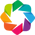
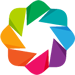
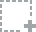
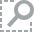
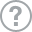
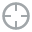
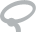
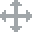
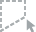
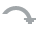
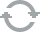
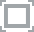
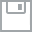
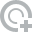
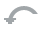
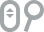
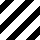
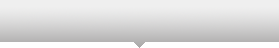
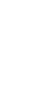
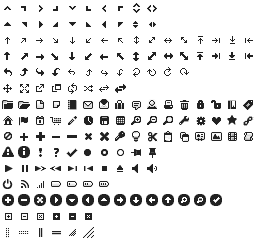
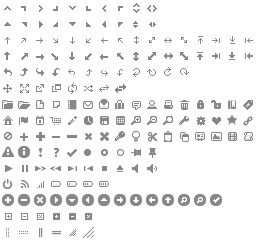
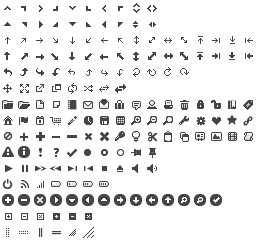
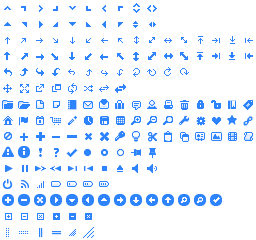
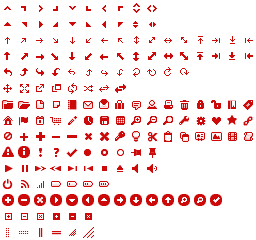
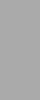

In [2]:
output_notebook()

In [3]:
jscode="""
        // Define a callback to capture errors on the Python side
        function callback(msg){
            console.log("Python callback returned unexpected message:", msg)
        }
        callbacks = {iopub: {output: callback}};

        // Generate a command to execute in Python
        var ranges = {x0: x_range.attributes.start,
                      y0: y_range.attributes.start,
                      x1: x_range.attributes.end,
                      y1: y_range.attributes.end}
        var range_str = JSON.stringify(ranges)
        var cmd = "%s(" + range_str + ")"
        
        // Execute the command on the Python kernel
        var kernel = IPython.notebook.kernel;
        kernel.execute(cmd, callbacks, {silent : false});
"""
p = figure(plot_width=400, plot_height=400, x_range=(-8240227.037, -8231283.905), y_range=(4974203, 4979238))
p.axis.visible = False

df = dd.from_castra('data/taxi.castra')
df = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']]
df = df.compute()

def create_image(ranges):
    xmin, ymin, xmax, ymax = ranges['x0'], ranges['y0'], ranges['x1'], ranges['y1']
    cvs = ds.Canvas(plot_width=p.plot_width, plot_height=p.plot_height, x_range=(xmin, xmax), y_range=(ymin, ymax))
    agg = cvs.points(df, 'pickup_longitude', 'pickup_latitude', count=ds.count('passenger_count'))
    pix = tf.interpolate(agg.count, (255, 204, 204), 'red', how='log')
    p.image_rgba(image=pix._to_channels(), x=[0], y=[0], dw=[2], dh=[1])
    push_notebook()
    
p.x_range.callback = CustomJS(args=dict(x_range=p.x_range, y_range=p.y_range), code=jscode % 'create_image')
p.y_range.callback = CustomJS(args=dict(x_range=p.x_range, y_range=p.y_range), code=jscode % 'create_image')

In [4]:
show(p)